## In this discussion, we will use Stock market data to create a correlation graph and analyze it using graph algorithms

## Installing the necessary packages

In [23]:
if (!require("igraph")) install.packages("igraph")
library ("igraph")
if (!require("clevr")) install.packages("clevr")
library ("clevr")

## Reading in the stock market data

In [25]:
# Reading the csv files
path = "finance_data/data/"
out.file<-""
file.names <- dir(path, pattern =".csv")
m <- matrix(, nrow = 0, ncol = 765)
sectors.table <- read.table("finance_data/Name_sector.csv",header=TRUE, sep=",", stringsAsFactors=TRUE)
sectors = c()
sectors.names <- c()
for(i in 1:length(file.names)){
    file <- read.table(paste("finance_data/data/",file.names[i],sep = ""),header=TRUE, sep=",", stringsAsFactors=FALSE)
    if(length(file$Close)==765){
        m <- rbind(m, matrix(file$Close, nrow=1, ncol=765))
        mystr <- substr(file.names[i], 1, nchar(file.names[i])-4)
        sector <- sectors.table$Sector[which(sectors.table$Symbol == mystr)]
        sectors.names = c(sectors.names, toString(sector))
    }
}

In [26]:
# Printing the sector details
com_num = length(sectors.names)
data_num = ncol(m)
sector.set<-as.factor(sectors.names)
sectors.index<-as.numeric(sector.set)
num_sector <- length(unique(sectors.index))
table(sector.set)

sector.set
    Consumer Discretionary           Consumer Staples 
                        84                         36 
                    Energy                 Financials 
                        34                         63 
               Health Care                Industrials 
                        60                         64 
    Information Technology                  Materials 
                        66                         24 
               Real Estate Telecommunication Services 
                        31                          4 
                 Utilities 
                        28 

In [27]:
# Printing some sample ticker symbols along with their sector information
head(sectors.table, n=20L)

,Symbol,Sector
,<fct>,<fct>
1,A,Health Care
2,AAL,Industrials
3,AAP,Consumer Discretionary
4,AAPL,Information Technology
5,ABBV,Health Care
6,ABC,Health Care
7,ABT,Health Care
8,ACN,Information Technology
9,ADBE,Information Technology


## Constructing a correlation graph using the daily stock market data

In [28]:
# Processing the files with p,q,r computations for the daily stock market data
allcomp = read.csv("finance_data/Name_sector.csv", header=TRUE, stringsAsFactors=FALSE)
filenames <- list.files("finance_data/data", pattern="*.csv")
filenames = paste("finance_data/data", filenames, sep="/")

L=c()
k=1
mat = matrix(0,length(filenames)-11,764)
for(j in c(1:length(filenames))){
    df = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    L[j] = dim(df)[1]
    if(L[j]==765){
        p = df[,5] 
        q = c()
        r = c()
        for(i in c(2:length(p))){
            q[i-1] = (p[i]-p[i-1])/p[i-1]
        }
        r = log(1+q)
        mat[k,] = r
        k = k+1
    }
}

allcomp["length"] = L
ind = which(L!=765)

allcomp <- allcomp[-ind,]

In [29]:
# Helper function for correlation computation
cal_cor <- function(conn, mat, allcomp){
    numCom = dim(mat)[1]
    cat("from","\t","to","\t","wt",file=conn)
    for(i in c(1:(numCom-1))){
        for(j in c((i+1):numCom)){
            ri = mean(mat[i,])
            rj = mean(mat[j,])
            mult = mean(mat[i,]*mat[j,])
            num = mult-(ri*rj)
            ri2 = mat[i,]^2
            rj2 = mat[j,]^2
            den = sqrt((mean(ri2)-(ri^2))*(mean(rj2)-(rj^2)))
            pij = num/den
            wij = sqrt(2*(1-pij))
            #val = 
            cat('\n',allcomp[i,1],'\t',allcomp[j,1],'\t',wij,file=conn)
        }
    }
    }

In [30]:
# Creating the correlation graph
conn <- file("edgelist.txt", "w")
cal_cor(conn, mat, allcomp)
close(conn)
elist <-read.delim("edgelist.txt",header=TRUE)
g <- graph.data.frame(elist, directed = FALSE)
E(g)$weight <- elist[,"wt"]

# Question 2

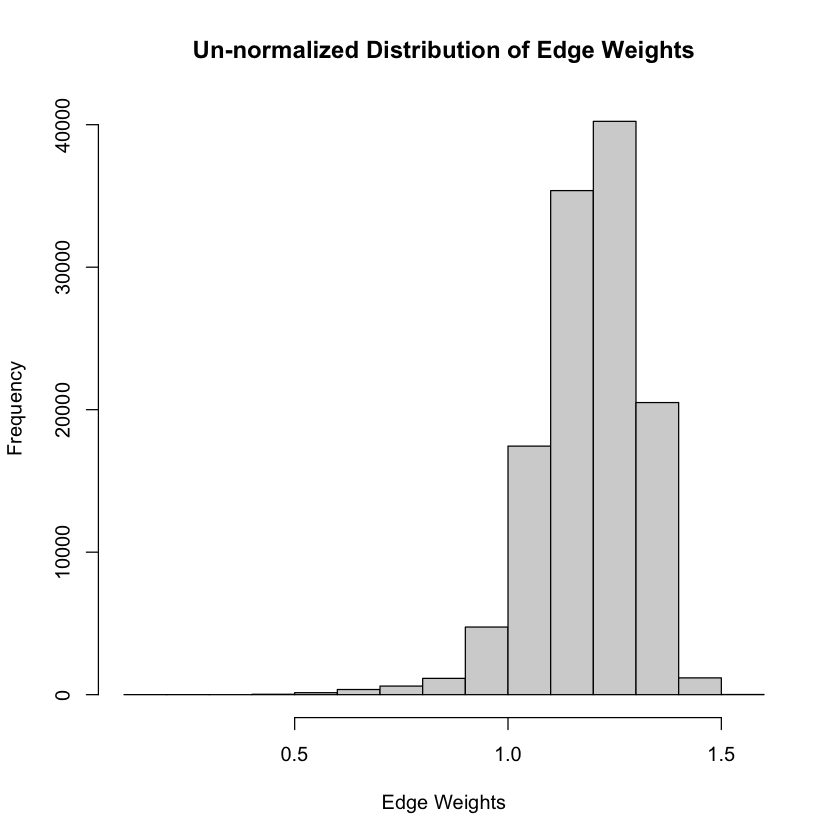

In [31]:
# Plotting the un-normalized distribution of edge weights
hist(elist[,"wt"],main="Un-normalized Distribution of Edge Weights",xlab="Edge Weights",ylab="Frequency")

## Minimum spanning tree and Clustering of Correlation graph

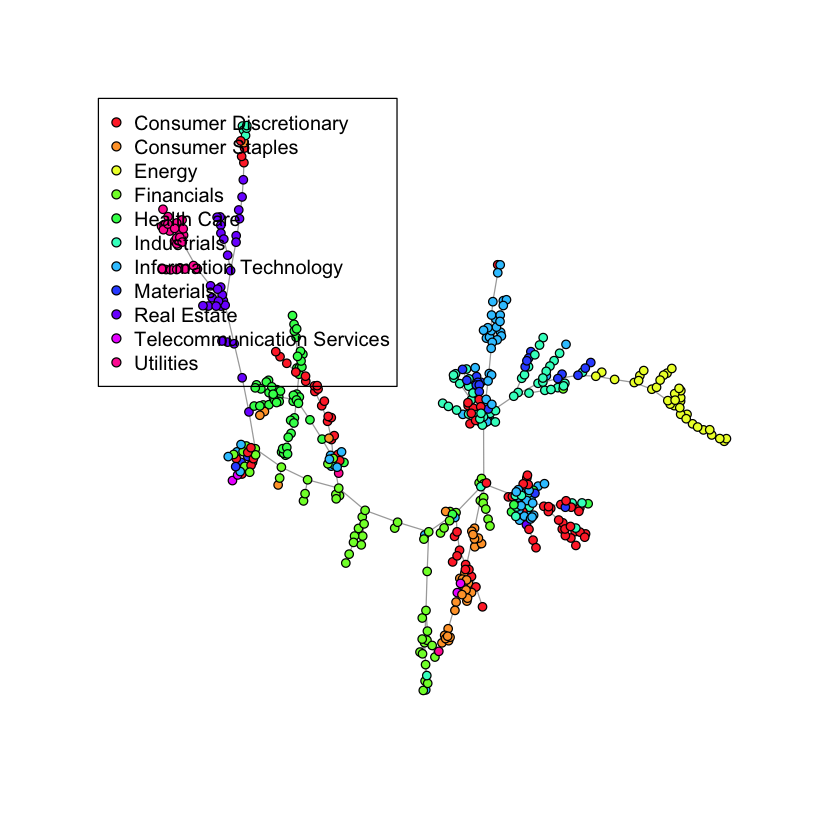

In [32]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_g <- mst(g, algorithm = 'prim')
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_g, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

[1] 33

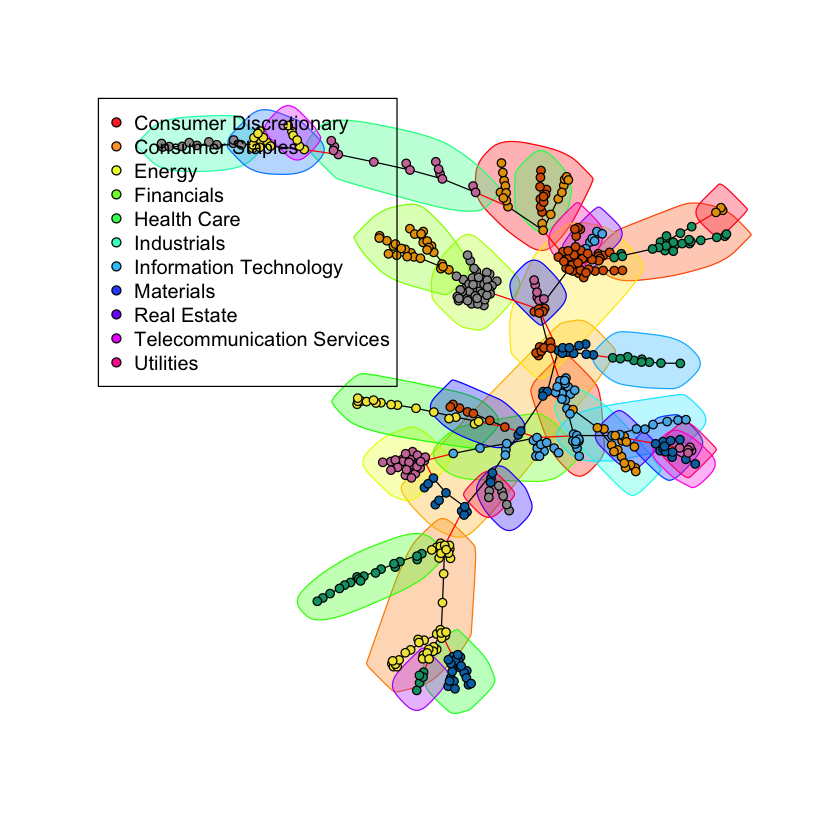

In [33]:
# Clustering of correlation graph
wc_daily <- walktrap.community(mst_g, weights= E(mst_g)$weights, modularity = TRUE) 
length(wc_daily)
plot(wc_daily, mst_g, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

Stocks belonging to the same or similar industries cluster together

# Question 4

In [34]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)
pred <- c(wc_daily$membership)
homogeneity(true, pred)
completeness(true,pred)

[1] 0.6826446

[1] 0.4792845

# Question 5

In [35]:
card_V = length(V(mst_g))
sum1 = 0
sum2 = 0
for(v in V(mst_g)){
    card_N = length(neighbors(mst_g,v))
    v_sect = sectors.index[v]
    card_Q = 0
    for(n in neighbors(mst_g, v)){
        if(sectors.index[n] == v_sect){
            card_Q = card_Q + 1
        }
    }
    card_S = length(sectors.index[sectors.index==v_sect])
    p1 = card_Q / card_N
    p2 = card_S / card_V
    sum1 = sum1 + p1
    sum2 = sum2 + p2
}
alpha1 = sum1 / card_V
alpha2 = sum2 / card_V
print("Alpha with first definition of P:")
print(alpha1)
print("Alpha with second definition of P:")
print(alpha2)

[1] "Alpha with first definition of P:"
[1] 0.8289301
[1] "Alpha with second definition of P:"
[1] 0.1141881


# Question 6

In [36]:
# Processing the files with p,q,r computations for the weekly stock market data
df["Day"] <-weekdays(as.Date(df[,1]))
L=c()
k=1
matw = matrix(0,length(filenames)-6,142)
for(j in c(1:length(filenames))){
    df = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    df["Day"]<-weekdays(as.Date(df[,1])) 
    df <- subset(df, Day=='Monday')
    L[j] = dim(df)[1]
    if(L[j]==143){
        p = df[,5] 
        q = c()
        r = c()
        for(i in c(2:length(p))){
            q[i-1] = (p[i]-p[i-1])/p[i-1]
        }
        r = log(1+q)
        matw[k,] = r
        k = k+1
    }
}

allcompw = read.csv("finance_data/Name_sector.csv", header=TRUE, stringsAsFactors=FALSE)
allcompw["length"] = L
ind = which(L!=143)
allcompw <- allcompw[-ind,]

In [ ]:
# Processing the files with p,q,r computations for the daily stock market data
allcomp = read.csv("finance_data/Name_sector.csv", header=TRUE, stringsAsFactors=FALSE)
filenames <- list.files("finance_data/data", pattern="*.csv")
filenames = paste("finance_data/data", filenames, sep="/")

L=c()
k=1
mat = matrix(0,length(filenames)-11,764)
for(j in c(1:length(filenames))){
    df = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    L[j] = dim(df)[1]
    if(L[j]==765){
        p = df[,5] 
        q = c()
        r = c()
        for(i in c(2:length(p))){
            q[i-1] = (p[i]-p[i-1])/p[i-1]
        }
        r = log(1+q)
        mat[k,] = r
        k = k+1
    }
}

allcomp["length"] = L
ind = which(L!=765)

allcomp <- allcomp[-ind,]

In [ ]:
# Creating the correlation graph
conn <- file("edgelist-weekly.txt", "w")
cal_cor(conn, matw, allcompw)
close(conn)
elistw <-read.delim("edgelist-weekly.txt",header=TRUE)
gw <- graph.data.frame(elistw, directed = FALSE)
E(gw)$weight <- elistw[,"wt"]

In [ ]:
# Plotting the un-normalized distribution of edge weights
hist(elistw[,"wt"],main="Un-normalized Distribution of Edge Weights",xlab="Edge Weights",ylab="Frequency")

## Minimum spanning tree and Clustering of Correlation graph

In [ ]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_gw <- mst(gw)
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_gw, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

There isn't the clear separation of different industries in this one. There is also a big cluster in the middle which the daily mst didn't have.

In [ ]:
# Clustering of correlation graph
wc_weekly <- walktrap.community(mst_gw, weights= E(mst_gw)$weights, modularity = TRUE) 
length(wc_weekly)
plot(wc_weekly, mst_gw, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [ ]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)[1:493]
pred <- c(wc_weekly$membership)
homogeneity(true, pred)
completeness(true,pred)

In [ ]:
card_V = length(V(mst_g))
sum1 = 0
sum2 = 0
for(v in V(mst_g)){
    card_N = length(neighbors(mst_g,v))
    v_sect = sectors.index[v]
    card_Q = 0
    for(n in neighbors(mst_g, v)){
        if(sectors.index[n] == v_sect){
            card_Q = card_Q + 1
        }
    }
    card_S = length(sectors.index[sectors.index==v_sect])
    p1 = card_Q / card_N
    p2 = card_S / card_V
    sum1 = sum1 + p1
    sum2 = sum2 + p2
}
alpha1 = sum1 / card_V
alpha2 = sum2 / card_V
print("Alpha with first definition of P:")
print(alpha1)
print("Alpha with second definition of P:")
print(alpha2)

# Question 7

In [ ]:
# Processing the files with p,q,r computations for the monthly stock market data
df["Month"]<-months(as.Date(df[,1]))
df["Month_Num"]<-substr(as.Date(df[,1]), 9, 10)

head(df)
L=c()
k=1
matm = matrix(0,length(filenames)-13,142)
for(j in c(1:length(filenames))){
    df = read.csv(filenames[j],header=TRUE, stringsAsFactors=FALSE)
    df["Month"]<-months(as.Date(df[,1])) 
    df["Month_Num"]<-substr(as.Date(df[,1]), 9, 10)
    df <- subset(df, Month_Num=='15')
    L[j] = dim(df)[1]
    if(L[j]==143){
        p = df[,5] 
        q = c()
        r = c()
        for(i in c(2:length(p))){
            q[i-1] = (p[i]-p[i-1])/p[i-1]
        }
        r = log(1+q)
        matm[k,] = r
        k = k+1
    }
}

allcompm = read.csv("finance_data/Name_sector.csv", header=TRUE, stringsAsFactors=FALSE)
allcompm["length"] = L
ind = which(L!=143)
allcompw <- allcompw[-ind,]

In [ ]:
# Creating the correlation graph
conn <- file("edgelist-monthly.txt", "w")
cal_cor(conn,matm,allcompm)
close(conn)
elistm <-read.delim("edgelist-monthly.txt",header=TRUE)
gm <- graph.data.frame(elistm, directed = FALSE)
E(gm)$weight <- elistm[,"wt"]

In [ ]:
# Plotting the un-normalized distribution of edge weights
hist(elistw[,"wt"],main="Un-normalized Distribution of Edge Weights",xlab="Edge Weights",ylab="Frequency")

In [ ]:
# Extracting and plotting the minimum spanning tree of the correlation graph
mst_gm <- mst(gm)
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_gm, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [ ]:
# Clustering of correlation graph
wc_monthly <- walktrap.community(mst_gm, weights= E(mst_gm)$weights, modularity = TRUE) 
length(wc_monthly)
plot(wc_monthly, mst_gm, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

In [ ]:
# Computing the homogeneity and completeness of the clustering
true<- c(sectors.index)[1:492]

pred <- c(wc_monthly$membership)

homogeneity(true, pred)
completeness(true,pred)

In [ ]:
card_V = length(V(mst_g))
sum1 = 0
sum2 = 0
for(v in V(mst_g)){
    card_N = length(neighbors(mst_g,v))
    v_sect = sectors.index[v]
    card_Q = 0
    for(n in neighbors(mst_g, v)){
        if(sectors.index[n] == v_sect){
            card_Q = card_Q + 1
        }
    }
    card_S = length(sectors.index[sectors.index==v_sect])
    p1 = card_Q / card_N
    p2 = card_S / card_V
    sum1 = sum1 + p1
    sum2 = sum2 + p2
}
alpha1 = sum1 / card_V
alpha2 = sum2 / card_V
print("Alpha with first definition of P:")
print(alpha1)
print("Alpha with second definition of P:")
print(alpha2)

# Question 8

As the length of time increases, the homogenity and completeness scores decreases. In the monthly section it looks like a list with each section of the list clearly partitioned off for a different sector. In the weekly portion it definitely is more clustered and there is more mixing of the industries, while in the daily section there's more of a tree structure with each branch corresponding to a different sector. They all are similar in the sense that each each of the nodes group together by industry. I think when it comes to predicting the sector of an unknown stock, the montly data would be the best to use. This is because in the clustering of the correlation graph, each industry of the linked list (list?) is very cleary separated, but in the MST it looks like they are all randomly appended to each other. Because of how clear the clustering looks given the MST, I think the monthly data would best predict the industry of a random stock.